In [52]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import math

In [53]:
def load_iris(ratio=0.8):
    features, target = datasets.load_iris(True)
    
    # 只保留0,1分类 -- 把任务变成二分类任务
    # 如果做多分类任务请注释这一段话
    idx = np.bitwise_or(target == 0, target == 1)
    features = features[idx]
    target = target[idx]
    
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

# 作业三

## 四、Logistic回归与最大熵模型

要求：

* 通过logistic回归来对只含两类的iris数据集进行二分类
* 利用梯度下降法（定步长）
* 在尽量不修改代码结构的前提下完成工作

ETA：1-5 hours

读取数据

In [54]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris()

### 一、定义线性回归函数

为了简化推导，记$\hat{Y} = WX+b$

预测 -- 取下述概率最大的值：

$$P(class=1|x) = \frac{\exp(\hat{Y})}{1+\exp(\hat{Y})}$$
$$P(class=0|x) = \frac{1}{1+\exp(\hat{Y})}$$

In [55]:
class Logistic:
    def __init__(self, in_channels):
        self.W = np.zeros(in_channels)
        self.b = 0
        
        
    def __call__(self, X):
        """计算 \hat{Y} = WX + b，其中WX为内积"""
        n=X.shape[0]
        m=X.shape[1]
        answer=[0 for i in range(n)] 
       # 对每一个实例计算WX+b并返回
        for i in range(n):
            sum=self.b
            for j in range(m):
                sum+=X[i][j]*self.W[j]
            answer[i]=sum
        return answer

    
    def predict(self, X):
        """预测X所属的类别"""
        
        # 实现它
        Y=self.__call__(X) ###获得计算完的Y
        prob=[1/(1+math.exp(y)) for y in Y] ###计算为0类的概率
        return [(p<0.5)+0 for p in prob] ##若概率<0.5则返回0 否则返回1
    
    
def accuracy(real, predict):
    """计算预测准确度"""
    return np.sum(real == predict)/real.size

In [56]:
# 测试LinearLayer是否能够正确调用
num_features = X_train.shape[-1]
f = Logistic(num_features)

f(X_train)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [57]:
f.predict(X_train)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [58]:
accuracy(Y_train, f.predict(X_train)) # 瞎猜 -- 50%左右的分类准确度

0.4875

### 二、定义误差 -- 对数似然函数

$$ L(Y, \hat{Y}) = \sum_{i=1}^{N} [y_i\hat{y}_i - log(1+\exp(\hat{y}_i))]$$

其中$Y$为真实值，$\hat{Y} = Wx + b$为预测值

注：$L(Y, \hat{Y}) \neq L(\hat{Y}, Y)$

In [67]:
class NegativeLogLikelihood:
    # 针对二项Logistic的负对数似然函数
    # 梯度下降法求解的问题实际上是 min. -L
    def __call__(self, real, predict):
        #assert len(real.shape) == 1
        #assert real.size == predict.size
        
        # 实现它
        n=len(real)
        sum=0
        for i in range(n):###按照公式计算负对数似然函数
            sum-=real[i]*predict[i]-math.log(1+math.exp(predict[i]))
        return sum


In [68]:
# 测试loss是否能够正确调用
loss = NegativeLogLikelihood()
loss(Y_train, f(X_train))

51.554596553266244

### 三、计算梯度

为了使用梯度下降法，需要计算梯度$(\frac{\partial L}{\partial W}, \frac{\partial L}{\partial b})$

利用链式法则：

$$ \frac{\partial L}{\partial W} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial W} $$
$$ \frac{\partial L}{\partial b} = \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{Y}_i} \frac{\partial \hat{Y}_i}{\partial b} $$

In [ ]:
def grad(Y, X, Y_out):
    """
    计算负对数似然函数在(X, Y)上关于W与b的偏导数
    Inputs:
      Y: shape (N, )
        类别的真实值
      X: shape (N, C)
        输入特征
      Y_out: shape (N, )
        Y_out = WX+b

    Outputs:
      dLdW: shape (C, )
      dLdb: shape (1, )
    """
    # 实现它
    N=len(X)
    M=len(X[-1]) ##有几维特征
    Grad=[0 for i in range(M+1)] 
    for j in range(M):###先计算关于W的导数
        for i in range(N):
            Grad[j]+=-Y[i]*X[i][j]+math.exp(Y_out[i])/(math.exp(Y_out[i])+1)*X[i][j]
    for i in range(N):##再计算关于b的导数
        Grad[-1]+=math.exp(Y_out[i])/(math.exp(Y_out[i])+1)
    return Grad[:M],Grad[-1]
    
    dLdY = None # dLdY.shape == (?, ) （?为占位符, 不需要回答..)
    dYdW = None # dYdW.shape == (?, 4)
    dYdb = None # dYdb.shape == (?, 1)
    
    dLdW = None # dLdW.shape == (4, )
    dLdb = None # dLdb.shape == (1, )
                 
    return dLdW, dLdb

In [ ]:
# 测试梯度是否正确计算
grad(Y_train, X_train, f(X_train))

In [ ]:
class GradientDescent:
    def __init__(self, step=1e-3, thres=1e3):
        self.step = step
        self.thres = np.abs(thres)
        
        
    def update(self, f:Logistic, dLdW, dLdb):
        """利用梯度dW来更新f的权重"""
        # 实现它
        M=len(dLdW) 
        for i in range(M):###更新负梯度方向的步长
            f.W[i]-=self.step*dLdW[i]
        f.b-=self.step*dLdb
       

In [70]:
# 测试梯度更新是否正常工作
opt = GradientDescent(1e-3)
f = Logistic(num_features)

print(f"before update: loss:{loss(Y_train, f(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}")

dLdW, dLdb = grad(Y_train, X_train, f(X_train))
opt.update(f, dLdW, dLdb)

print(f"after update: loss:{loss(Y_train, f(X_train)):.4f} accuracy:{accuracy(Y_train, f.predict(X_train))}")

before update: loss:55.4518 accuracy:0.4875
after update: loss:51.5546 accuracy:0.5125


### 四、把所有函数组合成一个完整的训练过程

In [71]:
num_features = X_train.shape[-1]
f = Logistic(num_features)
opt = GradientDescent(1e-5)
loss = NegativeLogLikelihood()

valid_losses = []
valid_accuracies = []
train_losses = []
train_accuracies = []
for i in range(1000):
    X, Y = X_train, Y_train
    
    Y_out = f(X)       
    dLdW, dLdb = grad(Y, X, Y_out)
    opt.update(f, dLdW, dLdb)
    
    # 记录中间结果
    cur_valid_loss = loss(Y_valid, f(X_valid))
    cur_valid_accu = accuracy(Y_valid, f.predict(X_valid))
    cur_train_loss = loss(Y, Y_out)
    cur_train_accu = accuracy(Y, f.predict(X))
    valid_losses.append(cur_valid_loss) 
    valid_accuracies.append(cur_valid_accu)
    train_losses.append(cur_train_loss)
    train_accuracies.append(cur_train_accu)
    
    if i%50 == 0:
        print(f"Iter {i}: loss {cur_train_loss:.4f}, accu: {cur_train_accu:.4f}, valid loss {cur_valid_loss:.4f}, valid accu {cur_valid_accu:.4f}")

Iter 0: loss 55.4518, accu: 0.5125, valid loss 13.8546, valid accu 0.4500
Iter 50: loss 53.4341, accu: 0.5125, valid loss 13.4752, valid accu 0.4500
Iter 100: loss 51.7700, accu: 0.5125, valid loss 13.1342, valid accu 0.4500
Iter 150: loss 50.2754, accu: 0.5250, valid loss 12.8075, valid accu 0.4500
Iter 200: loss 48.8805, accu: 0.6125, valid loss 12.4892, valid accu 0.5000
Iter 250: loss 47.5571, accu: 0.8375, valid loss 12.1789, valid accu 0.7500
Iter 300: loss 46.2926, accu: 0.9750, valid loss 11.8774, valid accu 0.9500
Iter 350: loss 45.0807, accu: 1.0000, valid loss 11.5852, valid accu 1.0000
Iter 400: loss 43.9174, accu: 1.0000, valid loss 11.3025, valid accu 1.0000
Iter 450: loss 42.7996, accu: 1.0000, valid loss 11.0295, valid accu 1.0000
Iter 500: loss 41.7251, accu: 1.0000, valid loss 10.7660, valid accu 1.0000
Iter 550: loss 40.6917, accu: 1.0000, valid loss 10.5118, valid accu 1.0000
Iter 600: loss 39.6975, accu: 1.0000, valid loss 10.2666, valid accu 1.0000
Iter 650: loss 

### 五、打印中间结果

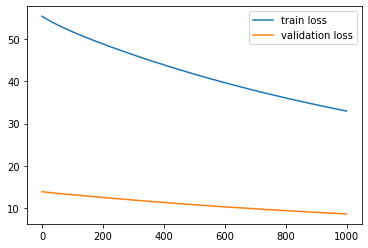

In [72]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])

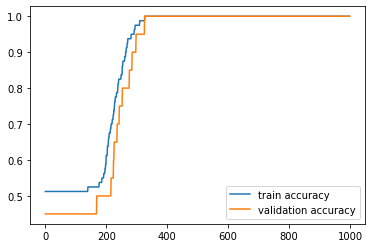

In [73]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.legend(["train accuracy", "validation accuracy"])

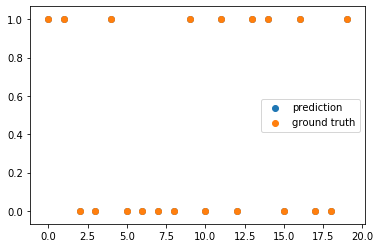

In [74]:
# 预测结果与真实结果重合
plt.scatter(np.arange(Y_valid.size), f.predict(X_valid))
plt.scatter(np.arange(Y_valid.size), Y_valid)
plt.legend(["prediction", "ground truth"])